In [2]:
import pandas as pd
import numpy as np
import doubleml as dml
from doubleml.rdd import RDFlex
from utils import fuzzy_treatment_assignment
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Data import (change the path accordingly)
path = Path(r"C:\\Users\\c.fusarbassini\\OneDrive - Hertie School\\25 ML-Strom\\2 Literatur & Research ideas\\AP 3\\data")
iso_ne = pd.read_parquet(path / "2025-08-12_iso-ne_dataset.parquet")
iso_ne = iso_ne[iso_ne.index.get_level_values('DateTime').year == 2019]  # filter for the year 2019

nyiso = pd.read_parquet(path / "2025-08-12_nyiso_dataset.parquet")
nyiso = nyiso[nyiso.index.get_level_values('DateTime').year == 2019]  # filter for the year 2019


In [3]:
nyiso_da_bids = pd.read_parquet(path / "NYISO" / "da_bids_2018-2019.parquet")
nyiso_da_bids = nyiso_da_bids[nyiso_da_bids.index.get_level_values('DateTime').year == 2019]  # filter for the year 2019

In [14]:
(nyiso_bids['Must Take Energy'] > 0).mean()

np.float64(0.34636213366690494)

In [4]:
nyiso_bids = pd.read_parquet(path / "NYISO" / "rt_bids_2018-2019.parquet")
nyiso_bids = nyiso_bids[nyiso_bids.index.get_level_values('DateTime').year == 2019]  # filter for the year 2019

In [24]:
iso_ne_bids = pd.read_parquet(path / "ISO-NE" / "rt_bids_2018-2019.parquet")
iso_ne_bids = iso_ne_bids[iso_ne_bids.index.get_level_values('DateTime').year == 2019] 

In [26]:
(iso_ne_bids.reset_index().groupby('Masked Asset ID')['Masked Lead Participant ID'].nunique() == 1).mean()

np.float64(0.9343832020997376)

In [2]:
iso_ne_bids = pd.read_parquet(path / "ISO-NE" / "rt_bids_2018-2019.parquet")
iso_ne_bids = iso_ne_bids[iso_ne_bids.index.get_level_values('DateTime').year == 2019]  # filter for the year 2019
nyiso_bids = pd.read_parquet(path / "NYISO" / "rt_bids_2018-2019.parquet")
nyiso_bids = nyiso_bids[nyiso_bids.index.get_level_values('DateTime').year == 2019]  # filter for the year 2019
nyiso_da_bids = pd.read_parquet(path / "NYISO" / "da_bids_2018-2019.parquet")
nyiso_da_bids = nyiso_da_bids[nyiso_da_bids.index.get_level_values('DateTime').year == 2019]  # filter for the year 2019

iso_notindf = set(iso_ne_bids.index.get_level_values('Masked Lead Participant ID')) - set(iso_ne.index.get_level_values('Masked Lead Participant ID'))
nyiso_notindf = set(nyiso_bids.index.get_level_values('Masked Lead Participant ID')) - set(nyiso.index.get_level_values('Masked Lead Participant ID'))
iso_ne_missing = iso_ne_bids[iso_ne_bids.index.get_level_values('Masked Lead Participant ID').isin(iso_notindf)]
nyiso_missing = nyiso_bids[nyiso_bids.index.get_level_values('Masked Lead Participant ID').isin(nyiso_notindf)]

iso_ne_missing["Max bid"] = iso_ne_missing.filter(regex="Segment [0-9]+ Price").max(axis=1)
nyiso_missing["Max bid"] = nyiso_missing.filter(regex="Segment [0-9]+ Price").max(axis=1)
iso_ne_missing["Min bid"] = iso_ne_missing.filter(regex="Segment [0-9]+ Price").min(axis=1)
nyiso_missing["Min bid"] = nyiso_missing.filter(regex="Segment [0-9]+ Price").min(axis=1)



C:\Users\c.fusarbassini\AppData\Local\Temp\ipykernel_8208\8349005.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\c.fusarbassini\AppData\Local\Temp\ipykernel_8208\8349005.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\c.fusarbassini\AppData\Local\Temp\ipykernel_8208\8349005.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [ ]:
# Marker mapping
plt.style.use("ggplot")
def count_dates(bids:pd.DataFrame) -> pd.DataFrame:
    bids = bids.copy()
    bids = bids.reset_index()
    bids["Date"] = bids["DateTime"].dt.date
    # Count rows per unit-company-date
    counts = bids.groupby(["Masked Asset ID", "Masked Lead Participant ID", "Date"]).size().reset_index(name="Count")

    # Classify full/partial
    counts["Bidding"] = np.where(
        counts["Count"] == 24, "full",
        np.where(counts["Count"] > 0, "partial", "none")
    )

    return counts

def plot_counts(counts:pd.DataFrame, figure_by="Masked Asset ID") -> None:
    
    style_map = {"full": ("o","red"), "partial": ("x", "blue"), "none": (None, None)}
    unique_by = "Masked Lead Participant ID" if figure_by != "Masked Lead Participant ID" else "Masked Asset ID"

    for j, subset in counts.groupby(figure_by):
        fig, ax = plt.subplots(figsize=(10, 6))
        unique = subset[unique_by].unique()
        for k, item in enumerate(unique):
            subsub = subset[subset[unique_by] == item]

            for key, (marker, color) in style_map.items():
                if marker is None:
                    continue
                data_status = subsub[subsub["Bidding"] == key]
                ax.scatter(pd.to_datetime(data_status["Date"]),
                    [k]*len(data_status), marker=marker, color=color)

        ax.set_title(f"{figure_by} {j}")
        ax.set_ylabel(unique_by)
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
        ax.set_yticks(range(len(unique)))
        ax.set_yticklabels(unique)
        ax.set_ylim(-0.5, len(unique) - 0.5)

        fig.savefig(f"figures/{j}.png")
        plt.close(fig)
        


counts = count_dates(nyiso_da_bids)
plot_counts(counts, figure_by="Masked Lead Participant ID")

Market: ISO-NE: pivotality, Bandwidth: 0.1, Share of hours: 33.05%
Market: ISO-NE: pivotality, Bandwidth: 0.2, Share of hours: 60.35%
Market: ISO-NE: pivotality, Bandwidth: 0.5, Share of hours: 98.39%
Market: NYISO: congestion, Bandwidth: 0.2, Share of hours: 30.47%
Market: NYISO: congestion, Bandwidth: 3, Share of hours: 61.87%
Market: NYISO: congestion, Bandwidth: 20, Share of hours: 95.82%


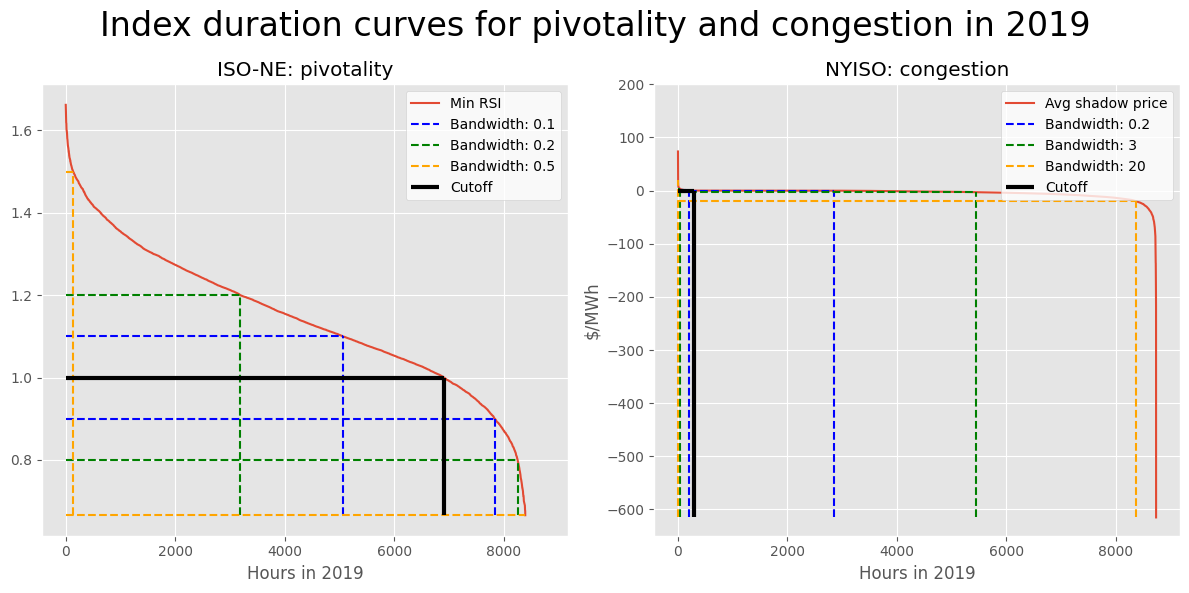

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 20
plt.style.use('ggplot')

# min_rsi = iso_ne.groupby('DateTime')['rsi'].min().sort_values(ascending=False).values
data_dict = {
    "ISO-NE: pivotality": (iso_ne.groupby('DateTime')['rsi'].min().sort_values(ascending=False).values, "Min RSI", 1, [0.1, 0.2, 0.5]),
    "NYISO: congestion": (nyiso.groupby('DateTime')['avg_cong'].max().sort_values(ascending=False).values, "Avg shadow price", 0.04, [0.2, 3, 20])  
}

fig, axes = plt.subplots(1,2, figsize=(12, 6), sharex=True, tight_layout=True)
colors = ['blue', 'green', 'orange']
k = 0


for market, (series, name, cutoff, bandwidth) in data_dict.items():

    ax = axes[k]
    ax.plot(series, label=name)
    ymin = series.min()
    for b, color in zip(bandwidth, colors):
        xmax_r = np.argmax(series <= (cutoff - b))
        xmax_l = np.argmax(series <= (cutoff + b))
        if xmax_r == 0:
            xmax_r = len(series) - 1
        bwidth = np.arange(xmax_l, xmax_r + 1, dtype=int)
        ax.hlines(max(cutoff - b, series.min()), xmin=0, xmax=xmax_r, color=color, linestyle='--')
        ax.hlines(cutoff + b, xmin=0, xmax=xmax_l, color=color, linestyle='--')
        ax.vlines(xmax_r, ymin=ymin, ymax=max(cutoff - b, series.min()), color=color, linestyle='--', label=f'Bandwidth: {b}')
        ax.vlines(xmax_l, ymin=ymin, ymax=cutoff + b, color=color, linestyle='--')
        #ax.fill_between(bwidth, y1=series[bwidth], y2=ymin, color=color, alpha=0.1)
        ax.set_xlabel('Hours in 2019')
        print(f"Market: {market}, Bandwidth: {b}, Share of hours: {len(bwidth) / len(series):.2%}")

    ax.hlines(cutoff, xmin=0, xmax=np.argmax(series <= cutoff), color='black', linestyle='-', label='Cutoff', linewidth=3)
    ax.vlines(np.argmax(series <= cutoff), ymin=ymin, ymax=cutoff, color='black', linestyle='-', linewidth=3)
    ax.legend(loc='upper right')
    ax.set_title(f'{market}')

    k += 1

ax.set_ylim(top=200)
ax.set_ylabel('$/MWh')
fig.suptitle('Index duration curves for pivotality and congestion in 2019', fontsize=24)
fig.savefig('bandwidths.svg', bbox_inches='tight', dpi=300)
